In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from tqdm import tqdm

# Computer Excersice 1

### (a):

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5),
                                (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.SVHN(root='./data', split='train',
                                        download=True, transform=transform)

test_data = torchvision.datasets.SVHN(root='./data', split='test',
                                       download=True, transform=transform)

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


### (b):

In [3]:
train_size = int(0.8*len(train_data))
validation_size = len(train_data) - train_size
test_size = len(test_data)

train_data, validation_data = torch.utils.data.random_split(train_data,[train_size, validation_size])

### (c):

In [4]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

### (d):

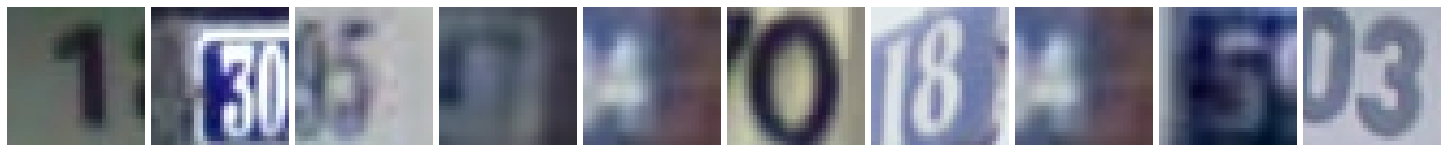

In [5]:

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Normalized the iputs from [-1,1] to [0,1] range
inputs = inputs.numpy().transpose((0, 2, 3, 1)) / 2 + 0.5

fig, axs = plt.subplots(nrows=1, ncols=10, constrained_layout=True, figsize=(20, 20))
for i in range(10):
  sample_index = random.randint(0, inputs.shape[0])
  axs[i].imshow(inputs[sample_index])
  axs[i].axis('off')
plt.show()

# Computer Exercise 2

In [6]:
def FC(layer1_size=128, layer2_size=64):
  return nn.Sequential( nn.Linear(32*32*3, layer1_size),
                        nn.Linear(layer1_size, layer2_size),
                        nn.ReLU(),
                        nn.Linear(layer2_size, 10),
                        nn.ReLU())

In [7]:
def out_size(W, F, S, P):
  return ((W-F+2*P) // S) + 1

In [8]:
def CNN(kernel=3):
  conv1_size= out_size(32, kernel, 1, 1)
  out_channels_1 = 10
  maxpool1_size = out_size(conv1_size, 2, 2, 0)
  conv2_size = out_size(maxpool1_size, kernel, 1, 1)
  maxpool2_size = out_size(conv2_size, 2, 2, 0)
  out_channels_2 = 20
  flatten_size = (maxpool2_size ** 2) * out_channels_2
  
  return nn.Sequential( nn.Conv2d(in_channels=3, kernel_size=kernel, stride=1,
                                  padding=1, out_channels=10),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
                        nn.Conv2d(in_channels=10, kernel_size=kernel, stride=1,
                                  padding=1, out_channels=20),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
                        nn.Flatten(),
                        nn.Linear(flatten_size, 64),
                        nn.ReLU(),
                        nn.Linear(64,10))

# Computer Exercise 3

In [9]:
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
def train_and_val_model(model, num_epochs=30, lr=0.001, validate=True, fc=True):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)

  train_loss = np.zeros(num_epochs)
  train_accu = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)
  val_accu = np.zeros(num_epochs)

  model=model.to(device)
  
  for epoch in tqdm(range(num_epochs), "Epoch Progress: "):  # loop over the dataset multiple times
    # Train
    with torch.enable_grad():
      model.train()
      running_loss = 0.
      correct_predictions = 0.
      for i, (inputs, labels) in enumerate(train_loader, 0):
        # zero the parameter gradients
        optimizer.zero_grad()
        # load to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        if fc:
          inputs = inputs.view(inputs.shape[0], -1)
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        correct_predictions += torch.sum(torch.argmax(outputs,dim=1) == labels.data)

      # get train statistics per epoch
      train_loss[epoch] = (running_loss / train_size)
      train_accu[epoch] = (correct_predictions / train_size)
    
    # Validate
    if validate:
      with torch.no_grad():
        model.eval()
        running_loss = 0.
        correct_predictions = 0.
        for i, (inputs, labels) in enumerate(validation_loader, 0):
          # load to device
          inputs = inputs.to(device)
          labels = labels.to(device)
          if fc:
            inputs = inputs.view(inputs.shape[0], -1)
          # forward
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          running_loss += loss.item() * inputs.size(0)
          correct_predictions += torch.sum(torch.argmax(outputs,dim=1) == labels.data)

        # get validation statistics per epoch
        val_loss[epoch] = (running_loss / validation_size)
        val_accu[epoch] = (correct_predictions / validation_size)

  return model, train_loss, train_accu, val_loss, val_accu

# Computer Exercise 4


In [ ]:
def print_loss_accu(train_loss, train_accu, val_loss, val_accu) :
  fig, (loss_ax, accu_ax) = plt.subplots(nrows=1, ncols=2)

  loss_ax.set_xlabel("Epochs")
  loss_ax.set_ylabel("Loss")
  loss_ax.plot(range(30), train_loss, label="train loss")
  loss_ax.plot(range(30), val_loss, label="validation loss")
  loss_ax.set_title("Train and Validation\nLoss Comparison")
  loss_ax.legend()

  accu_ax.set_xlabel("Epochs")
  accu_ax.set_ylabel("Accuracy")
  accu_ax.plot(range(30), train_accu, label="train accuracy")
  accu_ax.plot(range(30), val_accu, label="validation accuracy")
  accu_ax.set_title("Train and Validation\nAccuracy Comparison")
  accu_ax.legend()

  fig.tight_layout()
  res = pd.DataFrame([[train_loss[-1], val_loss[-1]],[train_accu[-1], val_accu[-1]]], index=["Loss", "Accuracy"], columns=["Train", "Validation"])
  print(f"\n{res}\n")

## FC Model

**default - layers (128, 64)**

In [ ]:
fc_1_model, fc_train_loss, fc_train_accu, fc_val_loss, fc_val_accu = train_and_val_model(FC())
print_loss_accu(fc_train_loss, fc_train_accu, fc_val_loss, fc_val_accu)

**layers (512, 256)**


In [ ]:
fc_2_model, fc_train_loss, fc_train_accu, fc_val_loss, fc_val_accu = train_and_val_model(FC(512, 256))
print_loss_accu(fc_train_loss, fc_train_accu, fc_val_loss, fc_val_accu)

**layers (64, 32)**


In [ ]:
fc_3_model, fc_train_loss, fc_train_accu, fc_val_loss, fc_val_accu = train_and_val_model(FC(64, 32))
print_loss_accu(fc_train_loss, fc_train_accu, fc_val_loss, fc_val_accu)

## CNN Model

**default - kernel (3)**

In [ ]:
cnn_1_model, cnn_train_loss, cnn_train_accu, cnn_val_loss, cnn_val_accu = train_and_val_model(CNN(), fc=False)
print_loss_accu(cnn_train_loss, cnn_train_accu, cnn_val_loss, cnn_val_accu)

**kernel (10)**

In [ ]:
cnn_2_model, cnn_train_loss, cnn_train_accu, cnn_val_loss, cnn_val_accu = train_and_val_model(CNN(10), fc=False)
print_loss_accu(cnn_train_loss, cnn_train_accu, cnn_val_loss, cnn_val_accu)

**kernel (1)**

In [ ]:
cnn_3_model, cnn_train_loss, cnn_train_accu, cnn_val_loss, cnn_val_accu = train_and_val_model(CNN(1), fc=False)
print_loss_accu(cnn_train_loss, cnn_train_accu, cnn_val_loss, cnn_val_accu)

# Problem 1

The findings are represented above each graph.
The architecture that performs the best on the validation set is CNN with kernel size 10.
We can notice from the findings that the Net is overfitting, since the train accuracy is higher than the validation accuracy.
The model succeeds in a good manner on the test set (accuracy = 0.911270), but it was less accurate for the vaidation set (accuracy = 0.888684)

# Computer Exercise 5


In [ ]:
test_loss = np.zeros(30)
test_accu = np.zeros(30)
num_epochs = 30
criterion = nn.CrossEntropyLoss()

In [ ]:
with torch.no_grad():
  cnn_2_model.eval()
  running_loss = 0.
  correct_predictions = 0.
  for i, (inputs, labels) in enumerate(test_loader, 0):
    # load to device
    inputs = inputs.to(device)
    labels = labels.to(device)
    # forward
    outputs = cnn_2_model(inputs)
    loss = criterion(outputs, labels)
    running_loss += loss.item() * inputs.size(0)
    correct_predictions += torch.sum(torch.argmax(outputs,dim=1) == labels.data)
    
  test_loss = (running_loss / test_size)
  test_accu = (correct_predictions.item() / test_size)

res = pd.DataFrame([[test_loss],[test_accu]], index=["Loss", "Accuracy"], columns=["Test"])
print(res)

# Problem 2

it is not guaranteed that the model we chose based on the validation set will give the best performance on the test set, since the validation set is different from the test set. However, we make the assumption that both sets are drawned from an identical distribution. That is why we expect the best modell on the validation set to be the best model on any other set (including the test set).

# Computer Exercise 6

We chose to finetune the pre-trained ResNet-18 model:

In [ ]:
def FT_RN_18():
  resNet_model = torchvision.models.resnet18(pretrained=True)

  # finetuning
  in_features = resNet_model.fc.in_features
  resNet_model.fc = nn.Linear(in_features, 10)

  return resNet_model

In [ ]:
resNet_model, train_loss, train_accu, val_loss, val_accu = train_and_val_model(FT_RN_18(), fc=False)
print_loss_accu(train_loss, train_accu, val_loss, val_accu)

# Problem 3

As mentioned before we chose to finetune the pre-trained ResNet-18 model. According to our knowledge, in the ResNet-18 model the first layers have already learned how to recognize simple shapes in an image, such as straight and curved lines, corners, etc. Hence, the majority of the work has already been done in the pre-trained Net.

# Problem 4

The finetuned ResNet-18 model has better acuuracy than the previous CNN and FC models although it recieved higher loss. Our best findings for each Net on the vllidation set is as follows:

| Valildation| FC       | CNN      | FT-RN-18 |
|:--------:|:--------:|:--------:|:--------:|
| Loss     | 0.604458 | 0.399554 | 0.421862 |
| Accuracy | 0.833879 | 0.888684 | 0.927723 |

We speculate that the performance increased in FT-RN-18 since the depth of it is much larger (18 layers). Also, the FT-RN-18 has been already trained with many examples from ImageNet dataset (more than 1 million images!). The dataset images contains many shapes (as lines and corners), that we can exploit for classifing the SVHN dataset.

# Problem 5

In [ ]:
lrs = [1E-8, 1E-6, 1E-5, 1E-4, 1E-3, 1E-2, 1E-0]
best_loss = np.infty

for lr in lrs:
  _, train_loss, _, _, _ = train_and_val_model(FT_RN_18(), lr=lr, validate=False, fc=False)
  if train_loss[-1] < best_loss:
    best_loss = train_loss[-1]
    best_lr = lr
  plt.plot(range(num_epochs), train_loss, label=('lr='+str(lr)))
plt.title('Train Loss\nLearning Rate Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

print(f"\nBest  learning rate is: {best_lr}\nRecieved loss: {best_loss}\n")

From our testing we see that the best loss was recieved with learning rate = 0.001. Bigger or smaller learning rates caused the loss to increase. For the larger learning rate, the reason for this behaviour can be explained because the step in each gradient diraction step is too big, and therefore, "overshoot" the desired minimum and cause the model difficulties in convergness. For too small learning rate, the steps in each iteration are too small and makes the model learning not effective and long lasting, so in 30 epochs we won't get fast enough to the minimum as in more larger learnign rates.

From our testing we see that the best loss was recieved with learning rate = 0.001. Bigger or smaller learning rates caused the loss to increase. For the larger learning rate, the reason for this behaviour can be explained because the step in each gradient diraction step is too big, and therefore, "overshoot" the desired minimum and cause the model difficulties in convergness. For too small learning rate, the steps in each iteration are too small and makes the model learning not effective and long lasting, so in 30 epochs we won't get fast enough to the minimum as in more larger learnign rates.